In [1]:
%load_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np
from src.taxonomy import getTaxonomy

### EDA

In [3]:
taxonomyDataFrame = pd.read_excel('data/raw/Тестовое задание.xlsx')
textsDataFrame = pd.read_excel('data/raw/Тестовое задание.xlsx', sheet_name='Тестовые данные')

taxonomy, taxonomyTree = getTaxonomy(
    taxonomyDataFrame=taxonomyDataFrame,
    textsDataFrame=textsDataFrame,
)

In [4]:
print(f'Кол-во листьев таксономии = {len(taxonomy.getLeafs())}\n')
print('Структкра таксономии. В скобках у казаны\n[\n кол-во правильно классифицированных текстов |\n кол-во частично правильно классифицированных текстов |\n кол-во неправильно классифицированных текстов\n]\n')
print(taxonomyTree.show(stdout=False))

Кол-во листьев таксономии = 76

Структкра таксономии. В скобках у казаны
[
 кол-во правильно классифицированных текстов |
 кол-во частично правильно классифицированных текстов |
 кол-во неправильно классифицированных текстов
]

Таксономия [180 | 138 | 2154]
└── Решаемые задачи [180 | 138 | 2154]
    ├── Визуальные работы [6 | 4 | 309]
    │   ├── Демонстрация рекламных конструкций [6 | 4 | 309]
    │   ├── Пилотажное шоу [0 | 0 | 0]
    │   ├── Пиротехнические представления [0 | 0 | 0]
    │   └── Световые шоу [0 | 0 | 0]
    ├── Внесение веществ [16 | 25 | 287]
    │   ├── Внесение удобрений, подкормок, стимуляторов [12 | 14 | 2]
    │   ├── Внесение энтомофагов, пестицидов [4 | 11 | 48]
    │   ├── Вызывание осадков [0 | 0 | 94]
    │   ├── Десикация [0 | 0 | 143]
    │   ├── Обработка реагентами и биологическими средствами для нейтрализации разлива вредных веществ [0 | 0 | 0]
    │   ├── Посевные работы [0 | 0 | 0]
    │   ├── Противообледенительные обработки площадных пространств [

In [5]:
print(f'Кол-во текстов = {len(textsDataFrame["Text"])}')
print(f'Средняя длина текста = {np.mean([len(x) for x in textsDataFrame["Text"]]):.2f} символов')

Кол-во текстов = 2472
Средняя длина текста = 185.20 символов


### Задачи

1. Предложи (в текстовом виде) несколько подходов плоской классификации (используя только “листья” таксономии);


- Использовать Fine Tuning предобученной языковой модели с добавлением линейного слоя для задачи классификации. Ускорить дообучение можно при помощи LoRA (QLora) адаптеров.

    Минусы: 
    - не учитываем названия классов на естественном языке
    - практически нет размеченных данных для обучения.

- Использовать промптп для классификации<br />(например https://developers.sber.ru/docs/ru/gigachat/prompts-hub/nlp/classification).

    Минусы: 
    - много токенов => дорого считать
    - ответ на естественном языке, который надо дополнительно обрабатывать

- Использовать эмбеддинги для вычисления близости между тексами и задачами<br />(например https://platform.openai.com/docs/guides/embeddings/use-cases).

    Плюсы: 
    - считать эмбеддинги дешевле, чем промпты
    - эмбеддинги для классов достаточно посчитать всего один раз
    - можно сортировать классы по уровню "близости" к тексту

2. Реализуй один из предложенных вариантов (желательно тот, который кажется перспективным, а не наиболее простой);

- Наиболее перспективным мне показался вариант с эмбеддингами. Для сравнения я использовал [модель для вычисления эмбеддингов от GigaChat](https://developers.sber.ru/docs/ru/gigachat/api/embeddings) и [модель text-embedding-3-large](https://platform.openai.com/docs/guides/embeddings) от OpenAI. 

- В процессе было замечено, что частыми ошибками при классификации является выбор классов:
    - Соревнования пилотов дронов
    - Перехват дронов-нарушителей
    
    Это связано с тем, что все тексты связаны с дронами, но токен "дрон" встречается только в этих двух классах. Чтобы это исправить, я также попробовал добавить фразу "с использованием дронов" в конце каждой темы при вычислении эмбеддингов.



In [6]:
from src.embeddings import computeEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings.gigachat import GigaChatEmbeddings

tasks = list(taxonomy.getLeafs().keys())
tasksDron = [f'{task} с использованием дронов' for task in tasks]
texts = textsDataFrame['Text'].tolist()

In [7]:
openAIEmbeddings = OpenAIEmbeddings(model="text-embedding-3-large")

tasksEmbeddingsOpenAI = computeEmbeddings(
    model=openAIEmbeddings, texts=tasks, keys=tasks,
    jsonPath='data/processed/tasksEmbeddingsOpenAI.json',
)

tasksEmbeddingsOpenAIDron = computeEmbeddings(
    model=openAIEmbeddings, texts=tasksDron, keys=tasks,
    jsonPath='data/processed/tasksEmbeddingsOpenAIDron.json',
)

textsEmbeddingsOpenAI = computeEmbeddings(
    model=openAIEmbeddings, texts=texts, keys=texts,
    jsonPath='data/processed/textsEmbeddingsOpenAI.json',
)

In [8]:
gigaChatEmbeddings = GigaChatEmbeddings(verify_ssl_certs=False)

tasksEmbeddingsGigaChat = computeEmbeddings(
    model=gigaChatEmbeddings, texts=tasks, keys=tasks,
    jsonPath='data/processed/tasksEmbeddingsGigaChat.json',
)

tasksEmbeddingsGigaChatDron = computeEmbeddings(
    model=gigaChatEmbeddings, texts=tasksDron, keys=tasks,
    jsonPath='data/processed/tasksEmbeddingsGigaChatDron.json',
)

textsEmbeddingsGigaChat = computeEmbeddings(
    model=gigaChatEmbeddings, texts=texts, keys=texts,
    jsonPath='data/processed/textsEmbeddingsGigaChat.json',
)

3. Оцени точность классификации на тестовых данных;

    Для оценки точности классификации я использовал 2 метрики:

    - Accuracy на верно классифицированных примерах (Cls == 1)
    - Точность классификации в тот же надкласс, для верно и частично-верно классифицированных примеров (Cls == 1 и Cls == 2) 

In [9]:
from src.metrix import topNTasksAccuracy, partiallyCorrectAcuracy
import matplotlib.pyplot as plt
from tqdm import tqdm

def topNAccuracy(n):

    N = range(1, n + 1)

    topNTasksGigaChatAccuracy = []
    topNTasksGigaChatDronAccuracy = []
    topNTasksOpenAIAccuracy = []
    topNTasksOpenAIDronAccuracy = []

    for n in tqdm(N):
        topNTasksGigaChatAccuracy.append(topNTasksAccuracy(
            textsDataFrame, tasksEmbeddingsGigaChat, textsEmbeddingsGigaChat, top_n=n
        )[0])
        topNTasksGigaChatDronAccuracy.append(topNTasksAccuracy(
            textsDataFrame, tasksEmbeddingsGigaChatDron, textsEmbeddingsGigaChat, top_n=n
        )[0])
        topNTasksOpenAIAccuracy.append(topNTasksAccuracy(
            textsDataFrame, tasksEmbeddingsOpenAI, textsEmbeddingsOpenAI, top_n=n
        )[0])
        topNTasksOpenAIDronAccuracy.append(topNTasksAccuracy(
            textsDataFrame, tasksEmbeddingsOpenAIDron, textsEmbeddingsOpenAI, top_n=n
        )[0])
    
    plt.figure(figsize=(10, 6))
    plt.plot(N, topNTasksGigaChatAccuracy, '--o', label='GigaChat')
    plt.plot(N, topNTasksGigaChatDronAccuracy, '--o', label='GigaChat + "c использованием дронов"')
    plt.plot(N, topNTasksOpenAIAccuracy, '--o', label='OpenAI')
    plt.plot(N, topNTasksOpenAIDronAccuracy, '--o', label='OpenAI + "c использованием дронов"')
    plt.xticks(N)
    plt.title('Accuracy при совпадении одной из топ N наиболее близких тем')
    plt.ylabel('Accuracy')
    plt.xlabel('N')
    plt.grid()
    plt.legend()
    plt.show()
        

100%|██████████| 5/5 [00:45<00:00,  9.05s/it]


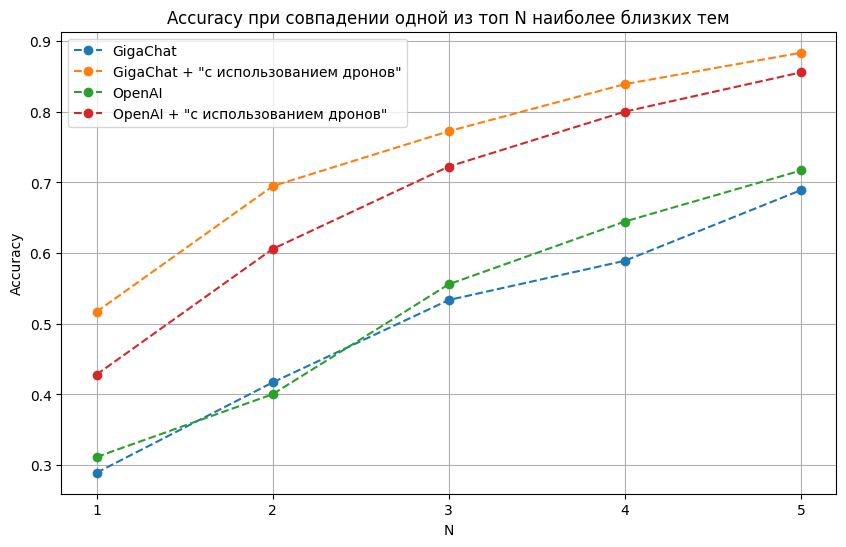

In [10]:
topNAccuracy(5)

In [11]:
def partiallyCorrectAcuracies():
    partiallyCorrectGigaChatAccuracy = partiallyCorrectAcuracy(
        taxonomy, textsDataFrame, tasksEmbeddingsGigaChat, textsEmbeddingsGigaChat
    )[0]
    partiallyCorrectGigaChatDronAccuracy = partiallyCorrectAcuracy(
        taxonomy, textsDataFrame, tasksEmbeddingsGigaChatDron, textsEmbeddingsGigaChat
    )[0]
    partiallyCorrectOpenAIAccuracy = partiallyCorrectAcuracy(
        taxonomy, textsDataFrame, tasksEmbeddingsOpenAI, textsEmbeddingsOpenAI
    )[0]
    partiallyCorrectOpenAIDronAccuracy = partiallyCorrectAcuracy(
        taxonomy, textsDataFrame, tasksEmbeddingsOpenAIDron, textsEmbeddingsOpenAI
    )[0]

    print('Точность классификации в тот же надкласс, что и верный ответ:')
    print(f' - GigaChat                            {partiallyCorrectGigaChatAccuracy:.3f}')
    print(f' - GigaChat + "с использовнием дронов" {partiallyCorrectGigaChatDronAccuracy:.3f}')
    print(f' - OpenAI                              {partiallyCorrectOpenAIAccuracy:.3f}')
    print(f' - OpenAI + "с использовнием дронов"   {partiallyCorrectOpenAIDronAccuracy:.3f}')

In [12]:
partiallyCorrectAcuracies()

Точность классификации в тот же надкласс, что и верный ответ:
 - GigaChat                            0.497
 - GigaChat + "с использовнием дронов" 0.673
 - OpenAI                              0.478
 - OpenAI + "с использовнием дронов"   0.670


По метрикам лучшими оказались эмбеддинги GigaChat с добавлением "с использованием дронов" в названии каждого класса.

Видно, что топ 5 ближайших из 76 возможных тем покрывают почти 90% правильных ответов на тестовых данных. Также первая ближайшая тема почти в 70% случаях принадлежит тому же надклассу, что и правильная или частично правильная.

Классификация всех текстов с использованием GigaChat лежит в data/processed:

In [13]:
from src.embeddings import classifyText
textsDataFrameClassified = textsDataFrame.copy()
textsDataFrameClassified['Classified'] = textsDataFrameClassified['Text'].apply(lambda text: classifyText(
    text, tasksEmbeddingsGigaChatDron, textsEmbeddingsGigaChat, top_n=1
)[0])
textsDataFrameClassified.to_excel('data/processed/classified.xlsx', index=False)

4. Предложи подход(-ы) учета иерархиичной структуры таксономии для улучшения качества предсказаний.

Наиболее очевидным кажется подход последовательной классификации от корня таксономии к листьям. Это должно позволить постепенно уточнять специфику задачи, тем самым делая классификацию более стабильной. В случае с эмбеддингами, достаточно будет посчитать эмбеддинги для каждого узла в таксономии и на каждом шаге спускаться в наиболее близкий по подкласс.